In [2]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#ImageDataGenerator is a utility function defined within Keras. If you haven't imported it import it using
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from keras.preprocessing import image
from keras.engine import Layer
import numpy as np
import os
import warnings
import pandas as pd
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.applications.inception_resnet_v2 import preprocess_input
#Sequential
from keras.models import Model
from keras.layers.core import RepeatVector, Permute


from skimage.transform import resize
from skimage.io import imsave


from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import crop, pad
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from keras.models import Model, load_model,Sequential
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


Using TensorFlow backend.


In [2]:
%%time
# Get images
# initializing array
X = []
# traverse through all the images from the directory 
for filename in os.listdir('data/LAGdataset_200/'):
# and converting to array
    X.append(img_to_array(load_img('data/LAGdataset_200/'+filename)))
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html
#numpy array of floats
X = np.array(X, dtype=float)
#0-255 numbers for each colour channel
Xtrain = 1.0/255*X

CPU times: user 11 s, sys: 11.3 s, total: 22.3 s
Wall time: 22.5 s


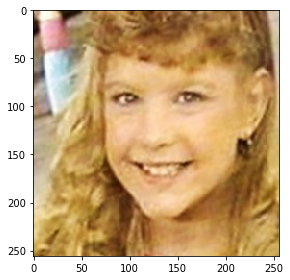

In [3]:
imshow(Xtrain[8])
plt.show()

In [4]:
%%time
#Load weights
#https://keras.io/applications/#inceptionresnetv2
inception = InceptionResNetV2(weights=None, include_top=True)
#https://github.com/fchollet/deep-learning-models/releases/download/v0.7/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
#https://ai.googleblog.com/2016/08/improving-inception-and-image.html
#Since I'm merging to models inception classifier and colourisation network
#need to specify which model is used
inception.load_weights('data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

CPU times: user 33.7 s, sys: 1.66 s, total: 35.4 s
Wall time: 41.3 s


In [5]:
def Colouring():
    #embed_input - merged category layer
    embed_input = Input(shape=(1000,))

    #Encoder
    #encoder_input is the original image
    encoder_input = Input(shape=(256, 256, 1,))
    #encoder_input passed as a parameter to the model
    #stride (2,2) means two pixels from the top and left padding
    #generate 64 new images from filters
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(encoder_input)  
    #https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    #128 new images
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(512, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

    #Fusion
    #Multiply the 1000 category layer by 1024 (32 * 32). 
    #Than to get 1024 rows with the final layer from the inception model.  
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    #It’s then reshaped from 2D to 3D, a 32 x 32 grid with the 1000 category pillars.
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    #These are then linked together with the output from the encoder model.
    fusion_output = concatenate([encoder_output, fusion_output], axis=3)
    #Apply a 254 filtered convolutional network with a 1X1 kernel, the final output of the fusion layer. 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    #upsampling is the opposite of convolution 
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    #Decoder output is the final output, encoder_input and embed_input are fused and then passed to decoder as decoder_input. fustion_output->decoder_input
    #model = before
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model = Colouring()
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 131200      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_206

In [6]:
%%time
# Image transformer
datagen = ImageDataGenerator(
    #tilt image
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

CPU times: user 233 µs, sys: 65 µs, total: 298 µs
Wall time: 303 µs


Creates a Callback Tensorboard object, you should capture that object and give it to the fit function of your model.

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
...
model.fit(...inputs and parameters..., callbacks=[tbCallBack])
This way you gave your callback object to the function. It will be ran during the training and will output files that can be used with tensorboard.

If you want to visualize the files created during training, run in your terminal

tensorboard --logdir path_to_current_dir/Graph 
https://stackoverflow.com/questions/41606854/tensorflow-permission-denied-error-location

In [7]:
%%time
#Batch size= 100 as my dataset is 1K pictures and steps_per_epoch= 10
#update 8k pictures 8000/32=250
#batch_size * steps_per_epoch = dataset_size

#Generate training data 
#100 images at the time

batch_size = 32 
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        #turn black and white and run through inception model
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        #select grayscale
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        #selects two color layers green–red and blue–yellow
        #put between -1 and 1
        Y_batch = lab_batch[:,:,:,1:] / 128
        #generate 100 images for each batch
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)
    
#Train model      
tensorboard = TensorBoard(log_dir="output")
#model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
#trainedmodel = model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=2, steps_per_epoch=32)






CPU times: user 5.16 s, sys: 146 ms, total: 5.31 s
Wall time: 9.61 s


In [8]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

In [9]:
%%time
batch_size = 32
trainedmodel = model.fit_generator(image_a_b_gen(batch_size), 
                                   callbacks=model_callbacks, 
                                   epochs=48, 
                                   steps_per_epoch=Xtrain.shape[0]/batch_size,
                                   verbose=1,
                                  )

Epoch 1/48
188/187 [==============================] - 768s 4s/step - loss: 0.0156 - acc: 0.6055
Epoch 2/48
188/187 [==============================] - 716s 4s/step - loss: 0.0069 - acc: 0.6257
Epoch 3/48
188/187 [==============================] - 729s 4s/step - loss: 0.0067 - acc: 0.6285
Epoch 4/48
188/187 [==============================] - 729s 4s/step - loss: 0.0064 - acc: 0.6443
Epoch 5/48
188/187 [==============================] - 736s 4s/step - loss: 0.0063 - acc: 0.6446
Epoch 6/48
188/187 [==============================] - 736s 4s/step - loss: 0.0062 - acc: 0.6443
Epoch 7/48
188/187 [==============================] - 738s 4s/step - loss: 0.0062 - acc: 0.6398
Epoch 8/48
188/187 [==============================] - 733s 4s/step - loss: 0.0060 - acc: 0.6420
Epoch 9/48
188/187 [==============================] - 732s 4s/step - loss: 0.0060 - acc: 0.6413
Epoch 10/48
188/187 [==============================] - 730s 4s/step - loss: 0.0061 - acc: 0.6420
Epoch 11/48
188/187 [==================

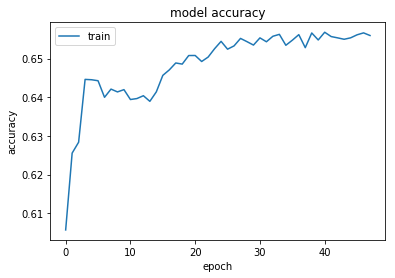

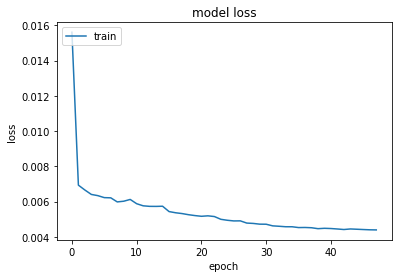

In [10]:
# summarize history for accuracy
plt.plot(trainedmodel.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.save(filepath)
model.save_weights("Colorization_Weights.h5")

In [18]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [4]:
# load json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [5]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 131200      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_206

In [15]:
%%time
# Load black and white images
colour_me = []
for filename in os.listdir('data/Dataset/Test/'):
        colour_me.append(img_to_array(load_img('data/Dataset/Test/'+filename)))
colour_me = np.array(colour_me, dtype=float)
#convert rgb to lab from selected grayscale
colour_me = (1.0/255*colour_me)
colour_me = gray2rgb(rgb2gray(colour_me))
colour_me_embed = create_inception_embedding(colour_me)
colour_me = rgb2lab(colour_me)[:,:,:,0]
colour_me = colour_me.reshape(colour_me.shape+(1,))
# Test model
# embeded colour as well, pass 2 arrays
output = model.predict([colour_me, colour_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

# Output colorizations
for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        #grayscale and lab based on predictions
        cur[:,:,0] = colour_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        decoded_imgs[i] = lab2rgb(cur)
        imsave("result/img_f"+str(i)+".png", lab2rgb(cur))

CPU times: user 3.26 s, sys: 317 ms, total: 3.58 s
Wall time: 3.59 s


In [6]:
plt.figure(figsize=(20, 6))
Xtest = []
Xtrain, Xtest = train_test_split(Xtrain, test_size=20, random_state=seed)
for i in range(10):
    # grayscale
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(Xtest)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(Xtest[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

NameError: name 'Xtrain' is not defined

<Figure size 1440x432 with 0 Axes>

Output of the Model


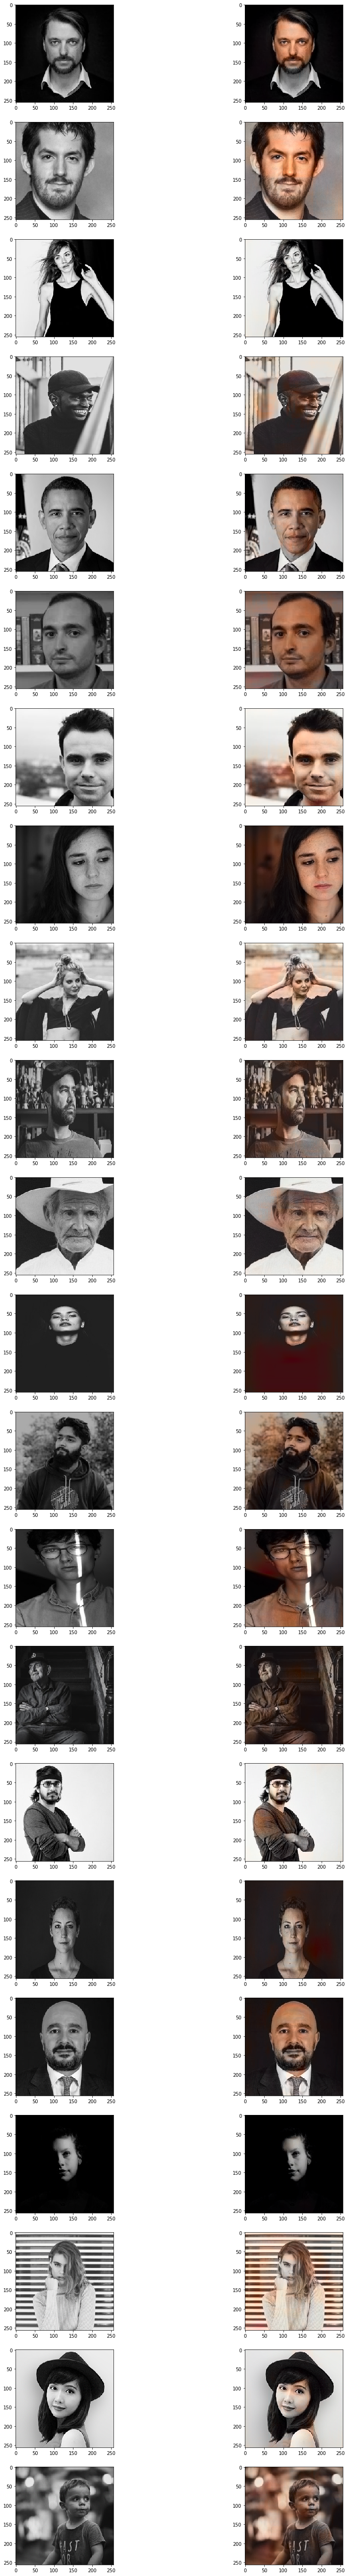

In [17]:
# Manual Testing of Images

import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt

fig, ax = plt.subplots(22, 2, figsize=(16,100))
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('data/Dataset/Test/'):
	colorize.append(img_to_array(load_img('data/Dataset/Test/'+filename)))
	ax[row,0].imshow(load_img('data/Dataset/Test/'+filename), interpolation='nearest')
	row +=1
    
colour_me = colorize

colour_me = np.array(colour_me, dtype=float)
#convert rgb to lab from selected grayscale
colour_me = (1.0/255*colour_me)
colour_me = gray2rgb(rgb2gray(colour_me))
colour_me_embed = create_inception_embedding(colour_me)
colour_me = rgb2lab(colour_me)[:,:,:,0]
colour_me = colour_me.reshape(colour_me.shape+(1,))
# Test model
# embeded colour as well, pass 2 arrays
output = model.predict([colour_me, colour_me_embed])
output = output * 128



row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((256, 256, 3))
	cur[:,:,0] = colour_me[i][:,:,0]
	cur[:,:,1:] = output[i]
	resImage = lab2rgb(cur)
	ax[row,1].imshow(resImage, interpolation='nearest')
	row +=1
    

# 	imsave("result/img_"+str(i)+".png", resImage)